In [ ]:
#!pip install PyYAML
import cv2
import numpy as np 
import os 
import yaml
from yaml.loader import SafeLoader

In [2]:
#Load YAML
with open('data.yaml', mode = 'r') as f:
        data_yaml = yaml.load(f, Loader=SafeLoader)
labels = data_yaml['names']
print(labels)



['person', 'Car', 'Taxi', 'Ambulance', 'Bus', 'Bycycle', 'SuperBike', 'CruiserBike', 'WineGlass', 'WineJar', 'WineBottel', 'Fruit', 'Graps', 'WineCork', 'Bowl', 'Chair', 'Plant&Gamla', 'Gamla', 'Plant', 'light', 'Dining', 'WoodenTabel', 'Frames', 'NightLight', 'TVScreen', 'Sofa', 'Jhumar', 'Horse', 'Girl', 'Boy', 'House', 'Fansing', 'Boat', 'Cow', 'Cat', 'Dog', 'LittleBoy', 'Dog', 'Bird', 'AiroPlane', 'Train', 'Human', 'Woman']


In [3]:
#Load YOLO Model onnx
yolo = cv2.dnn.readNetFromONNX('./Model3/weights/best.onnx')
#Set using cpu by prefereble backand through OpenCv
yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU) # WE have CPU Envoirment thats y using CPU if yoy have GPU use CUDA

In [4]:
#Load The Image
img = cv2.imread('./street_image.jpg')
image = img.copy()

row, col, d = image.shape #here d is RGB Color three sensities of the image  

#cv2.imshow('image', image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#get The YOLO predictions from the image 
#Step-1 Convert Image into Square Image (array)
max_rc = max(row, col)
input_image = np.zeros((max_rc, max_rc,3), dtype=np.uint8)
#overlay actual image into Empty image
input_image[0:row, 0:col] = image

#Step-2 get prediction from square array 
INPUT_WIDTH_YOLO = 640
INPUT_HEIGHT_YOLO = 640

blob = cv2.dnn.blobFromImage(input_image, 1/255, (INPUT_WIDTH_YOLO, INPUT_HEIGHT_YOLO), swapRB=True, crop=False)
yolo.setInput(blob)
#Pass the Yolo to Neural Network
preds = yolo.forward() #detection or prediction from yolo 


#cv2.imshow('input_image', input_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


# you can see how actual convert square matrix image with he help of Yolo Model


In [5]:
print(preds.shape)


(1, 25200, 48)


#  Number of Rows 25200 is Bounding Boxes detected by the Yolo model 
#  Each and every rows has those information which is column 
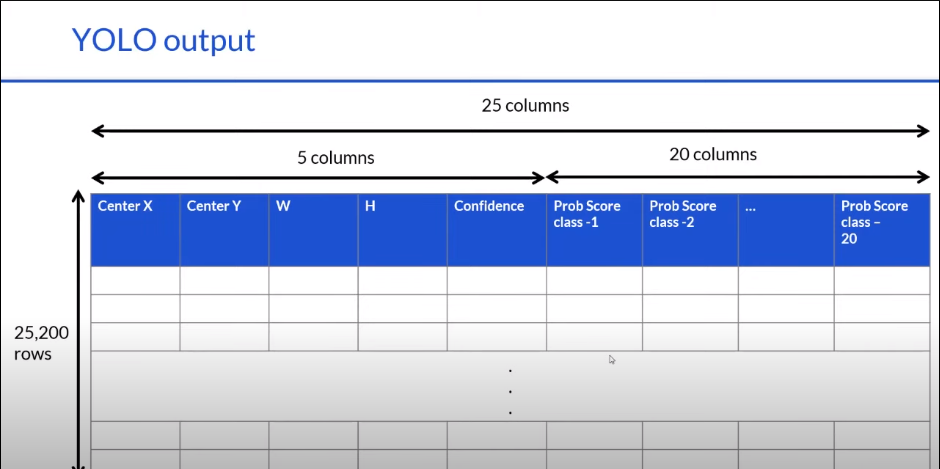

In [6]:
# Non Maximum Supression which is removing the duplicate Bounding boxes/ detection

#step:-1 filter detection based on confidence (0.4) and probability score (0.25)
detections = preds[0]
detections.shape
boxes = []
confidences = []
classes = []

#width and height of the image (input_image)
image_w, image_h = input_image.shape[:2]
x_factor = image_w/INPUT_WIDTH_YOLO
y_factor = image_h/INPUT_HEIGHT_YOLO

for i in range(len(detections)):
    row = detections[i]
    confidence_val = row[4] #confidence of detection on object
    if confidence_val > 0.4:
        class_score = row[5:].max() #maximum probability from 20 Objects
        class_id = row[5:].argmax() #get the index position at which max probabilty occur 

        if class_score  > 0.25:
            cx, cy, w, h = row[0:4]
            #construct bounding from four values 
            #left , top, width and height 
            left = int((cx - 0.5*w)*x_factor)
            top = int((cy - 0.5*h)*y_factor)
            width  = int(w*x_factor)
            height = int(h*y_factor)

            box_val = np.array([left, top, width, height])

            #append values into the list 
            confidences.append(confidence_val)
            boxes.append(box_val)
            classes.append(class_id)

#clean duplicate values 
boxes_np = np.array(boxes).tolist()
confidences_np = np.array(confidences).tolist()
#classes_np = np.array(classes).tolist()


#Non Maximum Supression 
index =  cv2.dnn.NMSBoxes(boxes_np, confidences_np,0.25,0.45).flatten()
# above index shows rows we need to consider for detections 

In [7]:
len(index) # number of face detection length 

18

In [8]:
# Draw The Bounding Box
for ind in index:
    #print(ind) # print index position 
    #extract bounding 
    x,y,w,h = boxes_np[ind]
    bounding_box_conf = int(confidences_np[ind]*100)
    classes_id = classes[ind]
    class_name = labels[classes_id]

    text = f'{class_name}: {bounding_box_conf}%'
    #print(text)
    cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0),2)
    cv2.rectangle(image, (x,y-30), (x+w, y), (255,255,255),-1)

    cv2.putText(image,text,(x,y-10), cv2.FONT_HERSHEY_PLAIN, 0.7,(0,0,0),1)
    




In [ ]:
cv2.imshow('original', img)
cv2.imshow('yolo_prediction', image)
cv2.waitKey(0)
cv2.destroyAllWindows()



In [ ]:
cap = cv2.VideoCapture('video.mp4')

while True:
    ret, frame = cap.read()
    if ret == False:
        print('unable to read video ')
        break
    pred_image = yolo.predictions(frame)
    cv2.imshow('YOLO', pred_image)
    if cv2.waitkey(1) == 27:
        break
cv2.destroyAllwindows()
cap.release()